In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda:0')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/'My Drive'

/content/drive/My Drive


In [3]:
from Jacobian.jacobian import *
from Jacobian.utils import *

In [4]:
_,_, train_loader, test_loader = get_data(train_batch_size=200, test_batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
!pip install pytorchcv
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model
thismodel = 'resnet20_cifar10'
model = ptcv_get_model(thismodel, pretrained=False)


     |████████████████████████████████| 440kB 5.3MB/s 


In [6]:
model = model.to("cuda")

In [7]:
model

CIFARResNet(
  (features): Sequential(
    (init_block): ConvBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBlock(
          (conv1): ConvBlock(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): ConvBlock(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (activ): ReLU(inplace=True)
      )
      (unit2): ResUnit(
        (body): ResBlock(
          (co

In [8]:
train_acc = compute_acc(model, train_loader, device)        
print(f'train ACC: {train_acc:.2f}, seed: {0}')
        
test_acc = compute_acc(model, test_loader, device)        
print(f'Test ACC: {test_acc:.2f}')

train ACC: 10.00, seed: 0
Test ACC: 10.00


In [10]:
optimizer = torch.optim.SGD(model.parameters(), .01, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100, 150], gamma=0.1, last_epoch=-1)

In [11]:
#import seaborn as sns
#sns.set()

criterion = nn.CrossEntropyLoss()

cost_list = []
train_acc_list = []


epoch_max = 75

for epoch in range(epoch_max):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
    # compute output
      features, targets = features.to("cuda:0"), targets.to("cuda:0")

      output = model(features)
      loss = criterion(output, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      cost_list.append(loss.item())
      if not batch_idx % 150:
        print (f'Epoch: {epoch+1:03d}/{epoch_max:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {loss:.4f}')
    
    """
    if epoch % 10 == 0:
      model.eval()
      full_J = construct_diagJ(model, test_loader, batch_size=100, device='cuda:0',  class_label_filter=0) # The P100 on Colab should have enough memory to do this
      M = full_J @ full_J.t() 
      del full_J
      u, v = torch.symeig(M)
      del M
      plt.hist(u.cpu().numpy(), bins=100)
      print("Max Eigenvalue:", u[-1].cpu().numpy())
      plt.title("ESD of JJ^T of ResNet20 using symeig over the Test Set, Epoch: " + str(epoch)) 
      plt.xlabel("Eigenvalue")
      plt.ylabel("Density")
      plt.show()
    """
    

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device)        
        print(f'Epoch: {epoch+1:03d}/{epoch_max:03d}\n'
              f'Train ACC: {train_acc:.2f}')
        
        train_acc_list.append(train_acc)
        #if np.isclose(train_acc, 0.0):
          #torch.save(model.state_dict(), 'MLP_truelabels_randomseed1')
          #pass
    scheduler.step()

#np.save('cost_MLP_truelabels_randomseed1', cost_list)
#np.save('trainacc_MLP_truelabels_randomseed1', train_acc_list)

 

Epoch: 001/075 | Batch 000/250 | Cost: 2.4140
Epoch: 001/075 | Batch 150/250 | Cost: 1.4872
Epoch: 001/075
Train ACC: 45.59
Epoch: 002/075 | Batch 000/250 | Cost: 1.4147
Epoch: 002/075 | Batch 150/250 | Cost: 1.2135
Epoch: 002/075
Train ACC: 54.77
Epoch: 003/075 | Batch 000/250 | Cost: 1.0970
Epoch: 003/075 | Batch 150/250 | Cost: 1.1119
Epoch: 003/075
Train ACC: 60.50
Epoch: 004/075 | Batch 000/250 | Cost: 0.9709
Epoch: 004/075 | Batch 150/250 | Cost: 0.9704
Epoch: 004/075
Train ACC: 62.03
Epoch: 005/075 | Batch 000/250 | Cost: 0.8482
Epoch: 005/075 | Batch 150/250 | Cost: 0.8709
Epoch: 005/075
Train ACC: 68.37
Epoch: 006/075 | Batch 000/250 | Cost: 0.7492
Epoch: 006/075 | Batch 150/250 | Cost: 0.8078
Epoch: 006/075
Train ACC: 68.98
Epoch: 007/075 | Batch 000/250 | Cost: 0.6779
Epoch: 007/075 | Batch 150/250 | Cost: 0.7380
Epoch: 007/075
Train ACC: 70.42
Epoch: 008/075 | Batch 000/250 | Cost: 0.6188
Epoch: 008/075 | Batch 150/250 | Cost: 0.7203
Epoch: 008/075
Train ACC: 70.57
Epoch: 0

KeyboardInterrupt: ignored

In [12]:
test_acc = compute_acc(model, test_loader,device)        
print(f'Test ACC: {test_acc:.2f}')

Test ACC: 76.57


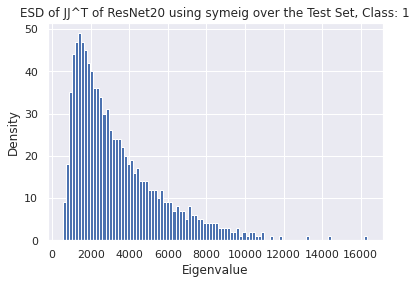

In [19]:
import seaborn as sns
sns.set()
class_label = 1
model.eval()
J = construct_diagJ(model, test_loader, batch_size=100, device='cuda:0', class_label_filter=class_label) # The P100 on Colab should have enough memory to do this
M = J @ J.t() 
del J
u, v = torch.symeig(M, eigenvectors=True)
del M    


plt.hist(u.cpu().numpy(), bins=100)
plt.title("ESD of JJ^T of ResNet20 using symeig over the Test Set, Class: " + str(class_label)) 
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()


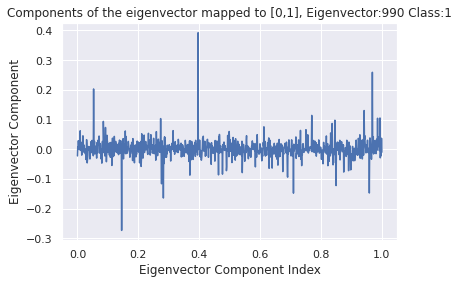

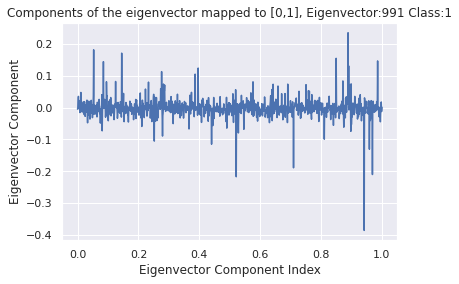

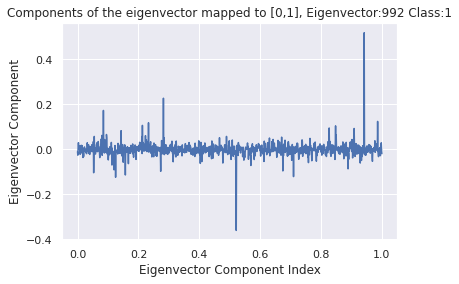

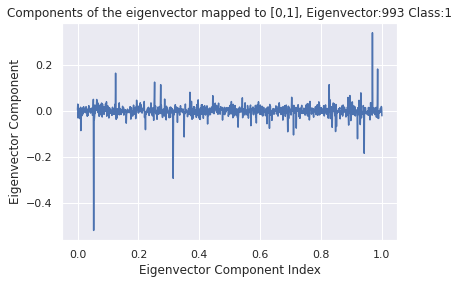

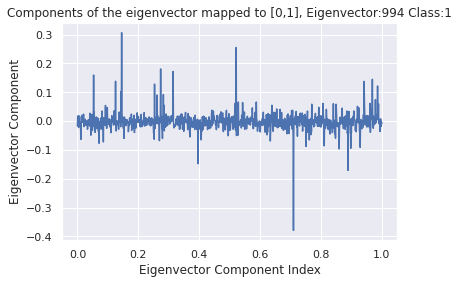

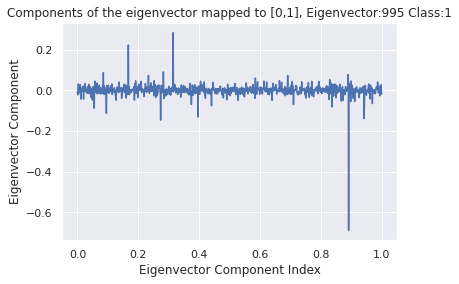

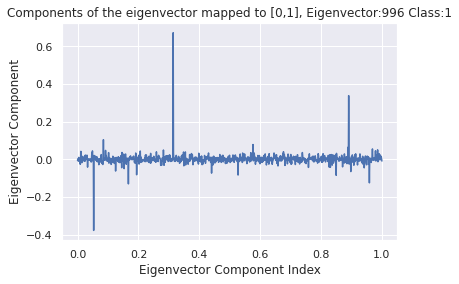

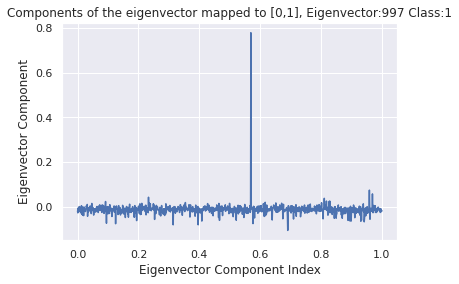

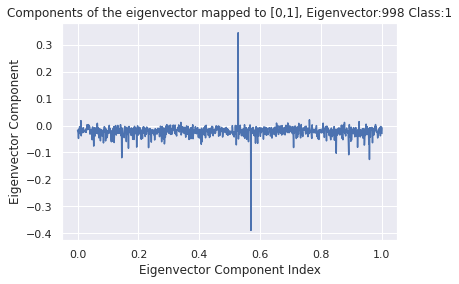

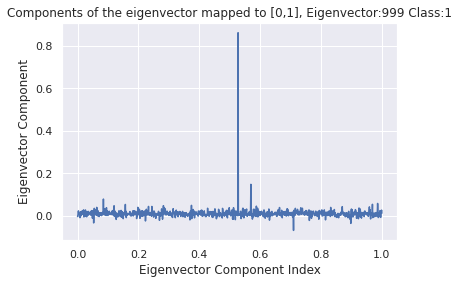

In [20]:
x = np.linspace(0,1, 1000)
for i in range(990,1000):
  plt.plot(x, v.cpu().numpy()[:,i])
  plt.xlabel("Eigenvector Component Index")
  plt.ylabel("Eigenvector Component")
  plt.title("Components of the eigenvector mapped to [0,1], Eigenvector:" + str(i) + " Class:" + str(class_label))
  plt.show()